In [36]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pytesseract
from pytesseract import Output

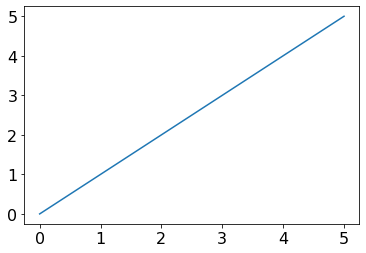

In [3]:
plt.rcParams.update({'font.size': 16,
                     'savefig.dpi': 300})
# Create an image plot
x = np.linspace(0,5,100)
plt.plot(x,x)
plt.savefig("plots/linear.png", bbox_inches='tight')

(1061, 1526, 3)


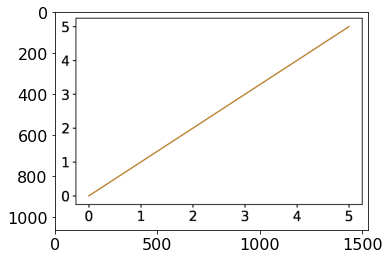

In [4]:
# Load image into numpy array and display it
img = cv2.imread("plots/linear.png")
print(img.shape)
# Clean up noise
# img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# ret, img = cv2.threshold(img,127,255,cv2.THRESH_BINARY)

plt.imshow(img)

In [5]:
class Rect:
    def __init__(self, x,y,w,h):
        self.x = x
        self.y = y
        self.w = w
        self.h = h

    @property
    def area(self):
        return (self.x+self.w) * (self.y+self.h)

    def intersect(self, other):
        no_x = self.x + self.w < other.x or self.x > other.x + other.w
        no_y = self.y + self.h < other.y or self.y > other.y + other.h
        return not no_x and not no_y

    def __str__(self):
        return f"({self.x}, {self.y}, {self.w}, {self.h})"

    def __repr__(self):
        return str(self)

In [6]:
def apply_min_contour_distance(rectangle_list):
    cleaned_contours = []

    # create a copy
    candidates = rectangle_list[:]
    while candidates:
        r1 = candidates[0]
        similars = [r1]
        # get all similar rects
        for r2 in candidates:
            if r1 != r2 and r1.intersect(r2):
                similars.append(r2)
        
        # use the box with the largest area
        areas = [r.area for r in similars]
        largest = areas.index(max(areas))
        cleaned_contours.append(similars[largest])
        
        # remove them as candidates
        for c in similars:
            candidates.remove(c)
    return cleaned_contours

def filter_by_area(rects, std_factor=1.5):

    # filter contours that are too far from the most n_boxes
    areas = np.array([r.area for r in rects])
    median = np.median(areas)
    std = np.std(areas)

    # only keep rectangles with an area of less than std_factor std
    rects = filter(lambda r: abs(r.area - median) <= std_factor * std, rects)
    return  list(rects)

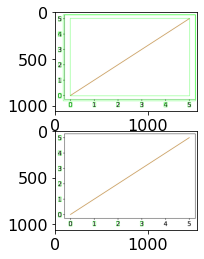

In [7]:
img = cv2.imread("plots/linear.png")
base_img = img.copy()

img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY_INV)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
rectangles = [Rect(*cv2.boundingRect(c)) for c in contours]

fig, (ax1, ax2) = plt.subplots(2,1)
img2 = img.copy()
for c in rectangles:
    img2 = cv2.rectangle(img2, (c.x,c.y), (c.x+c.w, c.y+c.h),(0, 255, 0), 2)
ax1.imshow(img2)

filtered = apply_min_contour_distance(rectangles)
filtered = filter_by_area(filtered)
for c in filtered:
    img = cv2.rectangle(img, (c.x,c.y), (c.x+c.w, c.y+c.h),(0, 255, 0), 2)
ax2.imshow(img)


('3', (910, 942, 32, 76))
('1', (405, 942, 30, 75))
('2', (656, 941, 32, 76))
('0', (148, 941, 34, 77))
('1', (37, 706, 55, 50))
('2', (35, 540, 57, 51))
('3', (35, 377, 57, 51))
('5', (35, 47, 57, 51))


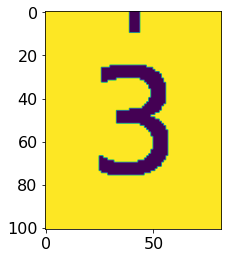

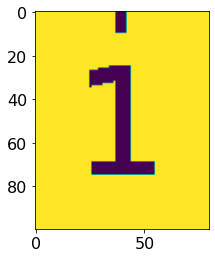

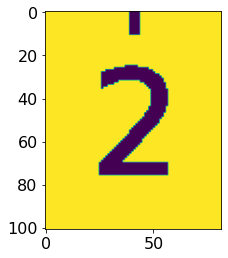

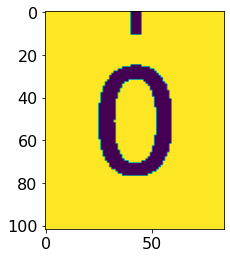

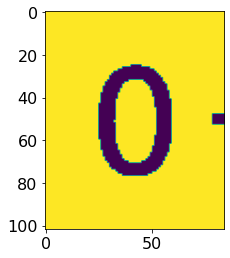

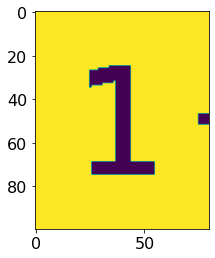

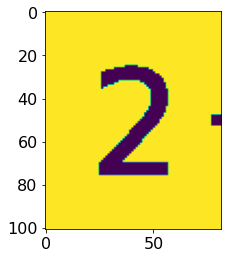

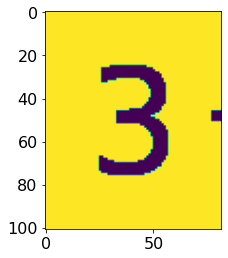

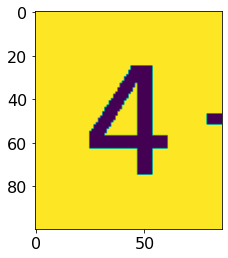

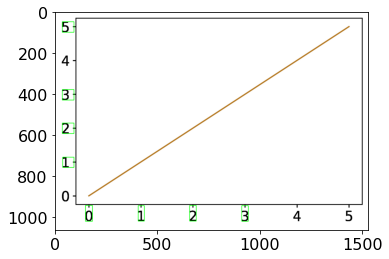

In [8]:
def add_border_to_box(r, img_shape, border_size=25):
    x = max(0, r.x - border_size)
    y = max(0, r.y - border_size)
    w = min(r.w + 2 * border_size, img_shape[0])
    h = min(r.h + 2 * border_size, img_shape[1])
    return Rect(x,y,w,h)

img_ocr = cv2.cvtColor(base_img.copy(), cv2.COLOR_BGR2GRAY)
img_ocr = cv2.threshold(img_ocr, 0, 255, cv2.THRESH_OTSU)[1]

letter_boxes = []

for rect in filtered:
    # extra borders to make the contours inside of the rectangle
    rect = add_border_to_box(rect, img.shape)
    roi = img_ocr[rect.y : rect.y + rect.h, rect.x : rect.x + rect.w]
    fig, ax = plt.subplots()
    plt.imshow(roi)
    d = pytesseract.image_to_data(roi, output_type=Output.DICT, config=f'--psm 13 -c tessedit_char_whitelist=0123456789')
    n_boxes = len(d['text'])
    for i in range(n_boxes):
        if int(d['conf'][i]) > 60:
            char_rect = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            original = Rect(rect.x + char_rect[0], rect.y + char_rect[1], char_rect[2], char_rect[3])
            letter_boxes.append((d["text"][i], original))
            print(letter_boxes[-1])

ocr_img = base_img.copy()
for c, box in letter_boxes:
    ocr_img = cv2.rectangle(ocr_img, (box.x, box.y), (box.x + box.w, box.y + box.h), (0,255,0), 2)

plt.imshow(ocr_img)


In [9]:
class PixelToLabelLookup:
    def __init__(self, all_label_boxes):
        """
        Class to convert found pixels (data values) to the corresponding value as indicated by the axis labels
        :param all_label_boxes:
        """
        self.x, self.y = self._separate_labels_for_axes(all_label_boxes)
        print(f"X-Labels: {self.x}")
        print(f"Y-Labels: {self.y}")
        self.x_func, self.y_func = self._create_lookup_fns()

    @staticmethod
    def _separate_labels_for_axes(labels, max_pixel_error=30):
        y_labels = []
        x_labels = []
        for val, r in sorted(labels, key=lambda t: t[1].y):
            if not y_labels:
                y_labels.append((int(val), r))
            elif abs(r.x - y_labels[-1][1].x) < max_pixel_error:
                y_labels.append((int(val), r))
            else:
                x_labels.append((int(val), r))
        return x_labels, y_labels

    def linear_regression(self, mean_points):
        points = np.array(mean_points).T
        assert len(points.shape) == 2

        x, y = points[0], points[1]

        s_xy = np.sum((x - x.mean()) * (y - y.mean()))
        s_xx = np.sum((x - x.mean()) ** 2)

        b = float(s_xy) / s_xx
        intercept = y.mean() - b * x.mean()

        def reg_fn(px):
            return np.round(intercept + b * px, 2)

        return reg_fn

    def _create_lookup_fns(self):
        mean_points_x = [(r.x + r.w / 2, val) for val, r in self.x]
        mean_points_y = [(r.y + r.h / 2, val) for val, r in self.y]
        print(mean_points_x)
        print(mean_points_y)
        return self.linear_regression(mean_points_x), self.linear_regression(mean_points_y)

    def x_lookup(self, px):
        return self.x_func(px)

    def y_lookup(self, px):
        return self.y_func(px)

    def __call__(self, x_arg, y_arg):
        return self.x_lookup(x_arg), self.y_lookup(y_arg)

label_lookup = PixelToLabelLookup(letter_boxes)

X-Labels: [(2, (656, 941, 32, 76)), (0, (148, 941, 34, 77)), (3, (910, 942, 32, 76)), (1, (405, 942, 30, 75))]
Y-Labels: [(5, (35, 47, 57, 51)), (3, (35, 377, 57, 51)), (2, (35, 540, 57, 51)), (1, (37, 706, 55, 50))]
[(672.0, 2), (165.0, 0), (926.0, 3), (420.0, 1)]
[(72.5, 5), (402.5, 3), (565.5, 2), (731.0, 1)]


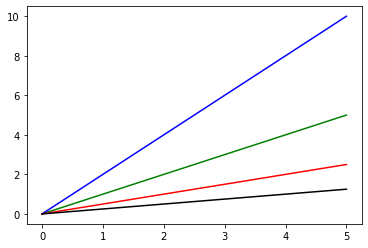

In [82]:
x = np.linspace(0,5,100)
plt.plot(x,x, 'g')
plt.plot(x, x*2, 'b')
plt.plot(x, x / 2, 'r')

plt.savefig("plots/linear_three_graphs.png")

found 3 colors/graphs


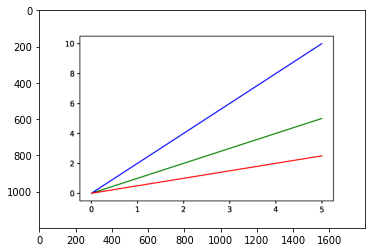

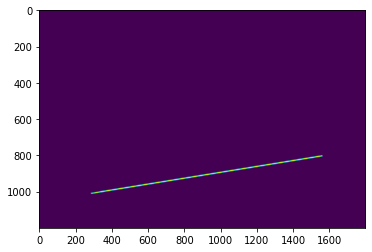

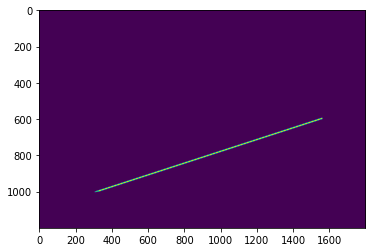

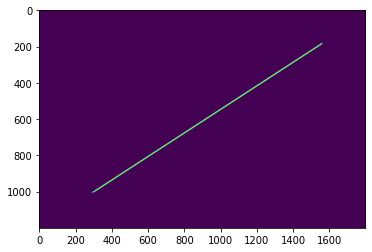

In [104]:
# If we have multiple graphs in a plot, we separate them by color.
# Change into the HSV color space because it better represents the perceived color.
# as we do not have many different colors we can easily threshold them to separate values, using the first (hue) value only
# problems: this does not work for black graphs

img = cv2.imread("plots/linear_three_graphs.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

hue_values = np.transpose(hsv_img, (2,0,1))[0].flatten()

# Get the most frequent hue values, i.e. present colors without noise
unq, counts = np.unique(hue_values, return_counts=True)
unique_threshold = 20
colors = unq[counts > unique_threshold]

color_masks = []
for c in colors:
    # define a range to make red possible as it is [0,100,100]
    lower = np.array([c,50,50])
    upper = np.array([c,255,255])

    mask = cv2.inRange(hsv_img, lower, upper)
    color_masks.append(mask)

    plt.subplots()
    plt.imshow(mask)

print(f"found {len(color_masks)} colors/graphs")